In [1]:
import glob
import tensorflow as tf

print(tf.__version__)

2.6.0


# Step 2. 데이터 읽어오기

In [2]:
import glob
import os
import pandas
import matplotlib.pyplot as plt

txt_file_path = './data/lyrics/*'
txt_list = glob.glob(txt_file_path)
raw_corpus = []

for txt_file in txt_list:
    with open(txt_file,"r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기 : ",len(raw_corpus))
print("Examples :\n",raw_corpus[:3])        

데이터 크기 :  187088
Examples :
 ['', '', 'All of this and more is for you']


# Step 3. 데이터 정제

### 3-1)정규표현식을 이용한 corpus 생성

In [4]:
import re
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

In [114]:
from tqdm import tqdm
print("------")
print(len(raw_corpus))
filtered_corpus = []

for sentence in tqdm(raw_corpus):
    if len(sentence)==0: continue
    
    preprocessd_sentence = preprocess_sentence(sentence)
    if len(preprocessd_sentence) < 130:
        filtered_corpus.append(preprocessd_sentence)

------
187088


100%|█████████████████████████████████████████████████████████████████████████████| 187088/187088 [00:15<00:00, 12002.45it/s]

175232


101444

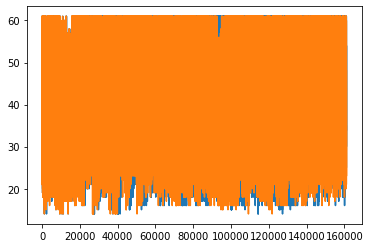

In [91]:
#필요없는 부분
import matplotlib.pyplot as plt
import pandas as pd
new_list = []
#토큰의 개수가 15개가 넘는 문장들은 삭제하기 위해 문장들의 길이 파악
for i in range(len(filtered_corpus)):
    new_list.append(len(filtered_corpus[i]))
    
df['length_of_corpus'] = pd.DataFrame(new_list)
df = df[df['length_of_corpus'] < ]
plt.plot(df)
len(df)
#print("Length of each corpus :\n",len(raw_corpus))
#토큰화를 해보고 나서 너무 긴 문장들은 삭제하는 함수를 써주자. 

### 3-2) 코퍼스를 텐서로 변환

In [133]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words = 12000,
        filters = ' ', #필터링은 이미 했음.
        oov_token = "<unk>"
    )
    tokenizer.fit_on_texts(corpus) #문자 데이터를 입력받아 리스트 형태로 리턴 
    tensor = tokenizer.texts_to_sequences(corpus) #텍스트 안의 단어들을 숫자의 시퀀스로 변환
    
    #입력데이터의 시퀀스 길이를 일정하게 맞춰준다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post',maxlen=10)
    #print(tensor,tokenizer)
    return tensor,tokenizer

In [134]:
tensor,tokenizer = tokenize(filtered_corpus)

In [135]:
print(tensor[0])  
#maxlen = 10 len(tensor)= 175232
#maxlen = 20 len(tensor)= 175232
#maxlen = 5 len(tensor)= 175232
#maxlen = 15 len(tensor)= 175232
#왜 maxlen을 바꿔도 텐서의 양은 같은지?

[ 2 24 19 42  8 98 26 28  7  3]


In [71]:
for idx in tokenizer.index_word:
    print(idx, ":",tokenizer.index_word[idx])

In [110]:
#필요없는 부분
import numpy as np
from tqdm import tqdm

print("지우기전의 tensor 개수  : ",len(tensor))
num = 0
for i in tqdm(range(len(tensor))):
    if len(np.nonzero(tensor[i])[0]) >=15:
        num+=1

    
print("지우고 난 후 tensor 개수  : ",num)

지우기전의 tensor 개수  :  134615


100%|█████████████████████████████████████████████████████████████████████████████| 134615/134615 [00:02<00:00, 67206.39it/s]

지우고 난 후 tensor 개수  :  993


In [99]:
print(tensor[50])

[ 2 14 33  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


### 3-3) corpus 텐서를 tf.data.Dataset객체로 변환

In [100]:
src_input = tensor[:,:-1]
tgt_input = tensor[:,1:]

In [101]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words +1

dataset = tf.data.Dataset.from_tensor_slices((src_input,tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 21), (256, 21)), types: (tf.int32, tf.int32)>

# Step 4. 평가 데이터셋 분리

In [102]:
from sklearn.model_selection import train_test_split

X = tensor[:,:-1]
y = tensor[:,1:]
enc_train, enc_val, dec_train, dec_val = train_test_split(X,y,test_size = 0.2)

# Step 5. 인공지능 만들기

In [103]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [104]:
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words+1, embedding_size,hidden_size)

In [105]:
for src_sample, tgt_sample in dataset.take(1): break
    
model(src_sample)

<tf.Tensor: shape=(256, 21, 12001), dtype=float32, numpy=
array([[[-1.21119730e-04, -1.19738885e-04,  1.70891144e-05, ...,
         -6.23908854e-05,  4.93881467e-04, -1.88387367e-05],
        [-5.13922889e-04, -3.59182392e-04,  7.76134257e-05, ...,
         -2.52882339e-04,  6.29051123e-04,  5.63973772e-05],
        [-6.62973442e-04, -4.80086019e-04,  2.25280673e-04, ...,
         -3.27938615e-04,  8.52526224e-04, -8.08773402e-05],
        ...,
        [ 3.57690989e-03,  2.19079480e-03, -6.19052094e-04, ...,
         -3.95590393e-03, -1.06324803e-03, -1.46384339e-03],
        [ 3.72518622e-03,  2.12947186e-03, -7.10590219e-04, ...,
         -3.97755671e-03, -1.04609784e-03, -1.43377075e-03],
        [ 3.85128707e-03,  2.06276379e-03, -7.91124592e-04, ...,
         -3.98900406e-03, -1.02527882e-03, -1.40316633e-03]],

       [[-1.21119730e-04, -1.19738885e-04,  1.70891144e-05, ...,
         -6.23908854e-05,  4.93881467e-04, -1.88387367e-05],
        [-1.51312124e-05,  8.52534577e-05,  6

In [106]:
model.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  5246976   
_________________________________________________________________
lstm_3 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_1 (Dense)              multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [108]:
optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(optimizer=optimizer, loss=loss) # 손실함수와 훈련과정을 설정했다.
model.fit(dataset,epochs=10) # 만들어둔 데이터셋으로 모델을 학습한다. 30번 학습을 반복하겠다는 의미다.

In [ ]:
#로컬 컴퓨터가 너무 느려서 lms상에서 돌렸어요.
#우선 결과는 붙여넣기 할게요. 
##13000개 정도 tensor를 가지고 한 결과 
Epoch 1/10
525/525 [==============================] - 134s 251ms/step - loss: 2.1619
Epoch 2/10
525/525 [==============================] - 137s 260ms/step - loss: 1.8200
Epoch 3/10
525/525 [==============================] - 136s 259ms/step - loss: 1.7123
Epoch 4/10
525/525 [==============================] - 136s 259ms/step - loss: 1.6304
Epoch 5/10
525/525 [==============================] - 136s 259ms/step - loss: 1.5593
Epoch 6/10
525/525 [==============================] - 136s 259ms/step - loss: 1.4944
Epoch 7/10
525/525 [==============================] - 136s 259ms/step - loss: 1.4348
Epoch 8/10
525/525 [==============================] - 137s 260ms/step - loss: 1.3797
Epoch 9/10
525/525 [==============================] - 137s 260ms/step - loss: 1.3283
Epoch 10/10
525/525 [==============================] - 136s 260ms/step - loss: 1.2802

In [ ]:
'<start> i love -> '<start> i love you , i m a fool <end> '
'<start> you are -> '<start> you are the greatest <end> '
'<start> always -> '<start> always , i m the one <end> '
'<start> you are -> '<start> you re the only one who knows that <end> '
'<start> sky ->'<start> sky is the limit and you know that you can have <end> '

In [ ]:
optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(optimizer=optimizer, loss=loss) # 손실함수와 훈련과정을 설정했다.
model.fit(enc_train,dec_train,epochs=10) # 만들어둔 데이터셋으로 모델을 학습한다. 30번 학습을 반복하겠다는 의미다.

In [ ]:
#175232개 정도 tensor를 가지고 한 결과 
Epoch 1/10
3366/3366 [==============================] - 157s 46ms/step - loss: 1.3962
Epoch 2/10
3366/3366 [==============================] - 153s 45ms/step - loss: 1.2438
Epoch 3/10
3366/3366 [==============================] - 153s 45ms/step - loss: 1.1475
Epoch 4/10
3366/3366 [==============================] - 152s 45ms/step - loss: 1.0684
Epoch 5/10
3366/3366 [==============================] - 152s 45ms/step - loss: 0.9996
Epoch 6/10
3366/3366 [==============================] - 151s 45ms/step - loss: 0.9387
Epoch 7/10
3366/3366 [==============================] - 152s 45ms/step - loss: 0.8846
Epoch 8/10
3366/3366 [==============================] - 151s 45ms/step - loss: 0.8365
Epoch 9/10
3366/3366 [==============================] - 151s 45ms/step - loss: 0.7947
Epoch 10/10
3366/3366 [==============================] - 151s 45ms/step - loss: 0.7590

In [ ]:
'<start> i love ->'<start> i love you so <end> '
'<start> you are ->'<start> you are the lady in my life <end> '
'<start> always ->'<start> always <end> '
'<start> you are ->'<start> you are the lady in my life <end> '
'<start> sky ->'<start> sky is the limit and you know that you can have <end> '

In [ ]:
#maxlen을 20으로 한 결과
Epoch 1/10
687/687 [==============================] - 151s 216ms/step - loss: 2.8733
Epoch 2/10
687/687 [==============================] - 161s 234ms/step - loss: 2.4726
Epoch 3/10
687/687 [==============================] - 163s 238ms/step - loss: 2.3140
Epoch 4/10
687/687 [==============================] - 164s 238ms/step - loss: 2.1969
Epoch 5/10
687/687 [==============================] - 164s 238ms/step - loss: 2.0994
Epoch 6/10
687/687 [==============================] - 164s 238ms/step - loss: 2.0119
Epoch 7/10
687/687 [==============================] - 164s 238ms/step - loss: 1.9304
Epoch 8/10
687/687 [==============================] - 164s 238ms/step - loss: 1.8543
Epoch 9/10
687/687 [==============================] - 164s 238ms/step - loss: 1.7825
Epoch 10/10
687/687 [==============================] - 164s 238ms/step - loss: 1.7146

In [ ]:
'<start> i love ->'<start> i love you , i m not gonna crack <end> '
'<start> you are ->'<start> you are the only one who knows that i m so glad <end> '
'<start> always ->'<start> always , baby , no <end> '
'<start> sky ->'<start> sky is the limit and you know that you can have <end> '

In [ ]:
#결과 4 maxlen=15로 조정한 결과
tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post',maxlen=15)
Epoch 1/10
684/684 [==============================] - 74s 101ms/step - loss: 4.6258
Epoch 2/10
684/684 [==============================] - 74s 107ms/step - loss: 3.9809
Epoch 3/10
684/684 [==============================] - 77s 112ms/step - loss: 3.7159
Epoch 4/10
684/684 [==============================] - 77s 112ms/step - loss: 3.5053
Epoch 5/10
684/684 [==============================] - 76s 111ms/step - loss: 3.3123
Epoch 6/10
684/684 [==============================] - 77s 112ms/step - loss: 3.1274
Epoch 7/10
684/684 [==============================] - 77s 112ms/step - loss: 2.9479
Epoch 8/10
684/684 [==============================] - 76s 112ms/step - loss: 2.7742
Epoch 9/10
684/684 [==============================] - 77s 112ms/step - loss: 2.6038
Epoch 10/10
684/684 [==============================] - 77s 112ms/step - loss: 2.4391

In [ ]:
'<start> i love ->'<start> i love you <end> '
'<start> you are ->'<start> you are my <unk> <end> '
'<start> always ->'<start> always <end> '
'<start> sky ->'<start> sky and richard <end> '

In [ ]:
#embedding_size = 512 & hidden_size = 1024
Epoch 1/10
684/684 [==============================] - 120s 169ms/step - loss: 3.5530
Epoch 2/10
684/684 [==============================] - 120s 176ms/step - loss: 3.0496
Epoch 3/10
684/684 [==============================] - 121s 177ms/step - loss: 2.8478
Epoch 4/10
684/684 [==============================] - 121s 176ms/step - loss: 2.6898
Epoch 5/10
684/684 [==============================] - 121s 177ms/step - loss: 2.5495
Epoch 6/10
684/684 [==============================] - 121s 177ms/step - loss: 2.4198
Epoch 7/10
684/684 [==============================] - 121s 177ms/step - loss: 2.2988
Epoch 8/10
684/684 [==============================] - 241s 352ms/step - loss: 2.1831
Epoch 9/10
684/684 [==============================] - 255s 372ms/step - loss: 2.0723
Epoch 10/10
684/684 [==============================] - 259s 378ms/step - loss: 1.9669

In [ ]:
'<start> i love ->'<start> i love you , liberian girl <end> '
'<start> you are ->'<start> you are the only one <end> '
'<start> always ->'<start> always searching for a minute <end> '
'<start> sky ->'<start> sky is the limit and you know that you can have <end> '
#표현의 풍부함을 평가할 수는 없을까? 
#정확도, 재현율 등등으로는 글을 평가할 수 없을 것 같은데?
#참신함을 평가할 순 없을까?

In [ ]:
#embedding_size = 256 & hidden_size = 512
Epoch 1/10
684/684 [==============================] - 91s 130ms/step - loss: 3.9067
Epoch 2/10
684/684 [==============================] - 108s 158ms/step - loss: 3.3920
Epoch 3/10
684/684 [==============================] - 108s 158ms/step - loss: 3.1702
Epoch 4/10
684/684 [==============================] - 108s 158ms/step - loss: 3.0441
Epoch 5/10
684/684 [==============================] - 109s 158ms/step - loss: 2.9414
Epoch 6/10
684/684 [==============================] - 109s 159ms/step - loss: 2.8537
Epoch 7/10
684/684 [==============================] - 108s 158ms/step - loss: 2.7765
Epoch 8/10
684/684 [==============================] - 109s 159ms/step - loss: 2.7045
Epoch 9/10
684/684 [==============================] - 109s 158ms/step - loss: 2.6345
Epoch 10/10
684/684 [==============================] - 109s 159ms/step - loss: 2.5639

In [ ]:
'<start> i love ->'<start> i love you , i love you <end> '
'<start> you are ->'<start> you are the one <end> '
'<start> always ->'<start> always in the world <end> '
'<start> sky ->'<start> sky is the limit and you know that you can do <end> '

In [ ]:
#embedding_size = 128 & hidden_size = 512
Epoch 1/10
684/684 [==============================] - 49s 68ms/step - loss: 3.9435
Epoch 2/10
684/684 [==============================] - 46s 67ms/step - loss: 3.3453
Epoch 3/10
684/684 [==============================] - 47s 68ms/step - loss: 3.1801
Epoch 4/10
684/684 [==============================] - 47s 68ms/step - loss: 3.0672
Epoch 5/10
684/684 [==============================] - 47s 68ms/step - loss: 2.9746
Epoch 6/10
684/684 [==============================] - 47s 68ms/step - loss: 2.8973
Epoch 7/10
684/684 [==============================] - 47s 68ms/step - loss: 2.8312
Epoch 8/10
684/684 [==============================] - 47s 68ms/step - loss: 2.7715
Epoch 9/10
684/684 [==============================] - 47s 68ms/step - loss: 2.7151
Epoch 10/10
684/684 [==============================] - 47s 68ms/step - loss: 2.6586

In [ ]:
'<start> i love ->'<start> i love you , i m a <unk> <end> '
'<start> you are ->'<start> you are the one <end> '
'<start> always ->'<start> always <unk> <end> '
'<start> sky ->'<start> sky is the limit and you know that you re gonna <end> '